In [1]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [2]:
! mkdir kaggle
%cd /kaggle
! mkdir tmp
%cd tmp

[Errno 2] No such file or directory: '/kaggle'
/home/kong/object_detection
/home/kong/object_detection/tmp


In [3]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
# Bağımlılıkların yüklenmesi
%pip install -qr requirements.txt 

%cd ../
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 10866, done.
remote: Total 10866 (delta 0), reused 0 (delta 0), pack-reused 10866
Receiving objects: 100% (10866/10866), 11.02 MiB | 856.00 KiB/s, done.
Resolving deltas: 100% (7499/7499), done.
/home/kong/object_detection/tmp/yolov5
Note: you may need to restart the kernel to use updated packages.
/home/kong/object_detection/tmp
Setup complete. Using torch 1.8.1+cu102 (Tesla V100-PCIE-32GB)


In [5]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np


import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from pathlib import Path

In [4]:
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [76]:
images_path = Path('/home/kong/object_detection/dataset/image/')
anno_path = Path("/home/kong/object_detection/dataset/annotations/")

In [73]:
def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]


def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(float(root.find("./object/bndbox/xmin").text))
        anno['ymin'] = int(float(root.find("./object/bndbox/ymin").text))
        anno['xmax'] = int(float(root.find("./object/bndbox/xmax").text))
        anno['ymax'] = int(float(root.find("./object/bndbox/ymax").text))
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [39]:
df_train = generate_train_df(anno_path)
class_dict = {'cat': 0, 'dog': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/home/kong/object_detection/dataset/image/cat....,331,442,0,20,5,258,437
1,/home/kong/object_detection/dataset/image/dog....,480,360,1,71,42,450,319
2,/home/kong/object_detection/dataset/image/dog....,459,500,1,1,33,455,473
3,/home/kong/object_detection/dataset/image/cat....,294,140,0,13,13,146,130
4,/home/kong/object_detection/dataset/image/dog....,171,246,1,12,7,152,242
...,...,...,...,...,...,...,...,...
1095,/home/kong/object_detection/dataset/image/dog....,403,335,1,29,20,399,332
1096,/home/kong/object_detection/dataset/image/dog....,499,426,1,64,23,488,418
1097,/home/kong/object_detection/dataset/image/cat....,349,300,0,4,4,325,298
1098,/home/kong/object_detection/dataset/image/dog....,415,499,1,16,27,405,489


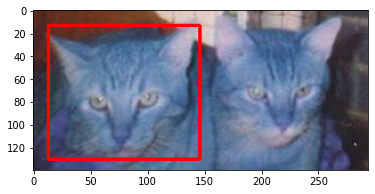

In [45]:
i=3
im = cv2.imread(str(df_train['filename'][i]))
cv2.rectangle(im, (df_train['xmin'][i],df_train['ymin'][i]), (df_train['xmax'][i],df_train['ymax'][i]), (255,0,0), 2)
plt.imshow(im)

In [1]:
import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join

# dirs = ['train', 'val']
classes = ['cat', 'dog']

def getImagesInDir(dir_path):
    image_list = []
    for filename in glob.glob(dir_path + '/*.jpg'):
        image_list.append(filename)

    return image_list

def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(dir_path, output_path, image_path):
    basename = os.path.basename(image_path)
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    out_file = open(output_path + basename_no_ext + '.txt', 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w,h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')



Finished processing: /home/kong/object_detection/dataset/annotations/


In [8]:
full_dir_path = "/home/kong/object_detection/dataset/annotations/"
output_path = "/home/kong/object_detection/dataset/label/"
image_paths = getImagesInDir("/home/kong/object_detection/dataset/image/")
list_file = open(output_path + '.txt', 'w')
for image_path in image_paths:
    list_file.write(image_path + '\n')
    convert_annotation(full_dir_path, output_path, image_path)
list_file.close()
print("Finished processing: " + full_dir_path)

Finished processing: /home/kong/object_detection/dataset/annotations/
